In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_file = "/content/drive/MyDrive/FYP/dataset.zip"

import zipfile

with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

In [ ]:
from tensorflow.keras import optimizers
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
import numpy as np
import os

In [ ]:
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        #brightness_range=[0.4,0.7],
        #channel_shift_range=60.0,
        fill_mode='nearest',
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'dataset/train',
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical')  # more than two classes

validation_generator = validation_datagen.flow_from_directory(
        'dataset/validation',
        target_size=(224, 224),
        batch_size=32,
        color_mode='rgb',
        class_mode='categorical',
        shuffle = False
)

Found 903 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [ ]:
# augmented images from train generator look like
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(4, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.grid(False)
plt.show()

In [ ]:
"""from keras.applications.vgg16 import VGG16
#Load VGG model with imagenet trained weights and without classifier/fully connected layers
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

#Make loaded layers as non-trainable.  important for to working with pre-trained weights
for layer in conv_base.layers:
	layer.trainable = False

conv_base.summary()"""

In [ ]:
from keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

conv_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3

In [ ]:
print("This is the number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=2e-5),
              metrics=['acc'])

In [ ]:
history = model.fit(
          train_generator,
          epochs=40,
          validation_data=validation_generator
          )

Epoch 1/40
29/29 [==============================] - 65s 1s/step - loss: 1.1011 - acc: 0.4319 - val_loss: 0.8641 - val_acc: 0.6667
Epoch 2/40
29/29 [==============================] - 35s 1s/step - loss: 0.8126 - acc: 0.6456 - val_loss: 0.6426 - val_acc: 0.7600
Epoch 3/40
29/29 [==============================] - 34s 1s/step - loss: 0.6471 - acc: 0.7209 - val_loss: 0.5232 - val_acc: 0.7800
Epoch 4/40
29/29 [==============================] - 34s 1s/step - loss: 0.5855 - acc: 0.7176 - val_loss: 0.4759 - val_acc: 0.8000
Epoch 5/40
29/29 [==============================] - 34s 1s/step - loss: 0.4821 - acc: 0.7918 - val_loss: 0.4258 - val_acc: 0.8133
Epoch 6/40
29/29 [==============================] - 34s 1s/step - loss: 0.4215 - acc: 0.8306 - val_loss: 0.3985 - val_acc: 0.8400
Epoch 7/40
29/29 [==============================] - 34s 1s/step - loss: 0.4151 - acc: 0.8283 - val_loss: 0.3448 - val_acc: 0.8533
Epoch 8/40
29/29 [==============================] - 33s 1s/step - loss: 0.3550 - acc: 0.85

In [ ]:
model.evaluate(validation_generator)

5/5 [==============================] - 4s 758ms/step - loss: 0.3111 - acc: 0.9200


[0.31113025546073914, 0.9200000166893005]

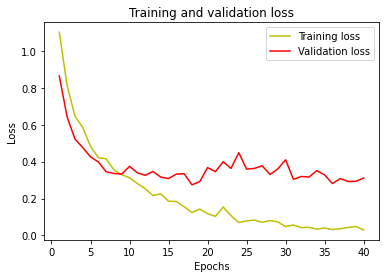

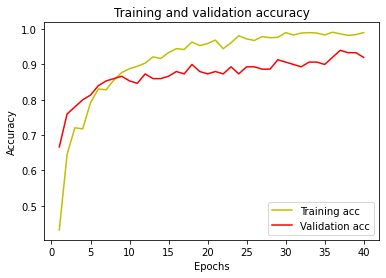

In [ ]:
import matplotlib.pyplot as plt

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

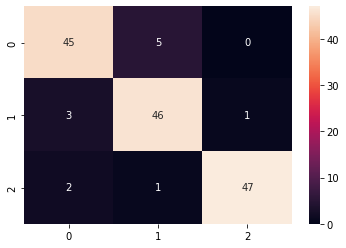

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred = y_pred.argmax(-1)

cm = confusion_matrix(validation_generator.classes, y_pred)
#print(cm)
sns.heatmap(cm, annot=True)

In [ ]:
model.save('models/modelTF1.h5') 

In [ ]:
os.stat('/content/models/modelTF1.h5').st_size

193058992

In [ ]:
!cp /content/models/modelTF1.h5 /content/drive/MyDrive/FYP

Testing

In [ ]:
import cv2
img_path = '/content/dataset/validation/pear/pear.n (302).jpg'
SIZE = 224
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.resize(img, (SIZE, SIZE))
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)

input_img = np.expand_dims(img, axis=0)
prediction_img = model.predict(input_img)
prediction_img = np.argmax(prediction_img, axis=1)
print("The prediction for this image is: ", prediction_img)